In [1]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, Convolution1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential, load_model
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.metrics import f1_score

print("reading data!")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# function to clean data
stops = set(stopwords.words("english"))

def cleanData(text, lowercase=False, remove_stops=False, stemming=False):
    txt = str(text)
    txt = re.sub(r'[^A-Za-z0-9\s]', r'', txt)
    txt = re.sub(r'\n', r' ', txt)

    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])

    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])

    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    return txt
print("cleaning data")
## join data
test['Is_Response'] = np.nan
alldata = pd.concat([train, test]).reset_index(drop=True)
y_alldata = [1 if x == 'happy' else 0 for x in alldata['Is_Response']]

# clean description
alldata['Description'] = alldata['Description'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True))
print("Done!")


Using TensorFlow backend.


reading data!
cleaning data
Done!


In [2]:
cols = ['Browser_Used','Device_Used']
from sklearn.preprocessing import LabelEncoder
for x in cols:
    lbl = LabelEncoder()
    alldata[x] = lbl.fit_transform(alldata[x])

In [48]:
MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 100

print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

texts = np.array(alldata['Description'])  # list of text samples
labels = [0.0,1.0]  # list of label ids
print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Indexing word vectors.
Found 400000 word vectors.
Found 68336 texts.
Found 73600 unique tokens.


In [49]:
df=data
df = pd.DataFrame(df)
df.columns = ['col'+ str(x) for x in df.columns]
df.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col490,col491,col492,col493,col494,col495,col496,col497,col498,col499
0,0,0,0,0,0,0,0,0,0,0,...,2974,7,392,3,47,65,20,42,111,198
1,0,0,0,0,0,0,0,0,0,0,...,664,1,58,7132,7,3,69,7,124,604
2,0,0,0,0,0,0,0,0,0,0,...,496,384,6408,222,1460,222,126,44,111,193
3,0,0,0,0,0,0,0,0,0,0,...,492,18,636,107,75,410,1187,1476,14,1476
4,0,0,0,0,0,0,0,0,0,0,...,157,1058,1629,47,7,54,3,327,798,489


In [50]:
df_all=alldata[cols]
df_all.head()

,Browser_Used,Device_Used
0,1,1
1,5,1
2,7,2
3,6,0
4,1,2


In [51]:
df_all=pd.get_dummies(df_all, columns=['Device_Used', 'Browser_Used'])
df_all.head()

,Device_Used_0,Device_Used_1,Device_Used_2,Browser_Used_0,Browser_Used_1,Browser_Used_2,Browser_Used_3,Browser_Used_4,Browser_Used_5,Browser_Used_6,Browser_Used_7,Browser_Used_8,Browser_Used_9,Browser_Used_10
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [52]:
df = pd.concat([df_all, df], axis = 1)
#pd.get_dummies(df, prefix=['Browser_Used'])
df.head()

,Device_Used_0,Device_Used_1,Device_Used_2,Browser_Used_0,Browser_Used_1,Browser_Used_2,Browser_Used_3,Browser_Used_4,Browser_Used_5,Browser_Used_6,...,col490,col491,col492,col493,col494,col495,col496,col497,col498,col499
0,0,1,0,0,1,0,0,0,0,0,...,2974,7,392,3,47,65,20,42,111,198
1,0,1,0,0,0,0,0,0,1,0,...,664,1,58,7132,7,3,69,7,124,604
2,0,0,1,0,0,0,0,0,0,0,...,496,384,6408,222,1460,222,126,44,111,193
3,1,0,0,0,0,0,0,0,0,1,...,492,18,636,107,75,410,1187,1476,14,1476
4,0,0,1,0,1,0,0,0,0,0,...,157,1058,1629,47,7,54,3,327,798,489


In [53]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', df.shape)
print('Shape of label tensor:', labels.shape)

X_train = np.array(df[:int(0.9*len(train))])
X_dev= np.array(df[int(0.9*len(train)):int(len(train))])
X_test= np.array(df[int(len(train)):])
target = y_alldata
Y_train = target[:int(0.9*len(train))]
Y_dev = target[int((0.9*len(train))):int(len(train))]
Y_test = target[int(len(train)):]

Shape of data tensor: (68336, 514)
Shape of label tensor: (2, 2)


In [54]:
# prepare embedding matrix
num_words = len(word_index)
embedding_matrix = np.zeros((num_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [96]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=df.shape[1]))

# Convolutional model (3x conv, flatten, 2x dense)
model.add(Convolution1D(64, 3, border_mode='same'))
model.add(Convolution1D(32, 3, border_mode='same'))
model.add(Convolution1D(16, 3, border_mode='same'))
model.add(Flatten())
model.add(Dropout(0.8))
model.add(Dense(180,activation='sigmoid'))
model.add(Dropout(0.8))
model.add(Dense(1,activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(X_train, Y_train,
          batch_size=64,
          nb_epoch=10) # batch_size=32 epochs=5 are optimum

Epoch 1/10
35038/35038 [==============================] - 11s - loss: 0.3873 - acc: 0.8340    
Epoch 2/10
35038/35038 [==============================] - 11s - loss: 0.2749 - acc: 0.8931    
Epoch 3/10
35038/35038 [==============================] - 11s - loss: 0.2457 - acc: 0.9082    
Epoch 4/10
35038/35038 [==============================] - 11s - loss: 0.2303 - acc: 0.9147    
Epoch 5/10
35038/35038 [==============================] - 11s - loss: 0.2142 - acc: 0.9225    
Epoch 6/10
35038/35038 [==============================] - 11s - loss: 0.2017 - acc: 0.9267    
Epoch 7/10
35038/35038 [==============================] - 11s - loss: 0.1928 - acc: 0.9296    
Epoch 8/10
35038/35038 [==============================] - 11s - loss: 0.1833 - acc: 0.9328    
Epoch 9/10
35038/35038 [==============================] - 11s - loss: 0.1734 - acc: 0.9392    
Epoch 10/10
35038/35038 [==============================] - 11s - loss: 0.1606 - acc: 0.9426    


In [97]:
from sklearn.metrics import f1_score, accuracy_score
output = model.predict(X_dev)
sub=[]
for i in range(len(output)):
    sub.append(output[i][0])
out = pd.DataFrame()
out['label']=sub
out['label'] = [1 if x >= 0.5 else 0 for x in out['label']]
print(accuracy_score(Y_dev,out['label']))
print(f1_score(Y_dev,out['label']))

0.870056497175
0.905172413793


In [100]:
i=0
score=[]
X=[]
while i <1:
    temp=sub
    temp = [1 if x >= i else 0 for x in temp]
    score.append(accuracy_score(Y_dev,temp))
    X.append()
    temp=sub
    i=i+0.01

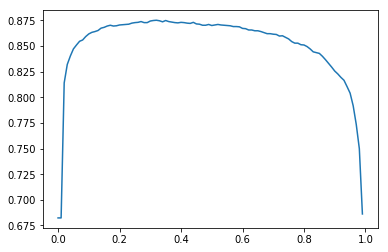

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(X,score)
plt.show()

In [34]:
model.save('my_model2.h5')
def to_labels(x):
    if x > 0.55:  # cutoff - you can change it and see if accuracy improves or plot AUC curve. 
        return "happy"
    return "not_happy"
submission = model.predict(X_test)
sub=[]
for i in range(len(submission)):
    sub.append(submission[i][0])

submission_data = pd.DataFrame({'User_ID':test.User_ID, 'Is_Response':sub})
submission_data['Is_Response'] = submission_data['Is_Response'].map(lambda x: to_labels(x))
submission_data = submission_data[['User_ID','Is_Response']]
submission_data.to_csv("submission3.csv", index=False)

In [113]:
import lightgbm as lgb
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.01, 
    'max_depth': 7, 
    'num_leaves': 100, 
    'feature_fraction': 0.3, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'max_bin':500,
    'num_threads':4,
    'device':'cpu'}

In [ ]:
d_train = lgb.Dataset(X_train, label = Y_train)
lgb_cv = lgb.cv(params, d_train, num_boost_round=500, nfold= 5, shuffle=True, stratified=True, verbose_eval=20, 
                early_stopping_rounds=40)

[20]	cv_agg's binary_error: 0.297134 + 0.00260155
[40]	cv_agg's binary_error: 0.293367 + 0.00281201
[60]	cv_agg's binary_error: 0.292339 + 0.00312045
[80]	cv_agg's binary_error: 0.291055 + 0.00316235
[100]	cv_agg's binary_error: 0.289942 + 0.00306161
[120]	cv_agg's binary_error: 0.286803 + 0.00348759
[140]	cv_agg's binary_error: 0.285319 + 0.00330582
[160]	cv_agg's binary_error: 0.284434 + 0.00261923
[180]	cv_agg's binary_error: 0.282522 + 0.00333225
[200]	cv_agg's binary_error: 0.281295 + 0.0032816
[220]	cv_agg's binary_error: 0.279868 + 0.00357331
[240]	cv_agg's binary_error: 0.278812 + 0.00420242
[260]	cv_agg's binary_error: 0.278384 + 0.00431577
[280]	cv_agg's binary_error: 0.27767 + 0.00416356
[300]	cv_agg's binary_error: 0.276414 + 0.00456262
[320]	cv_agg's binary_error: 0.276072 + 0.00479363
[340]	cv_agg's binary_error: 0.274759 + 0.00535246
[360]	cv_agg's binary_error: 0.274588 + 0.00503148
[380]	cv_agg's binary_error: 0.27396 + 0.00500779
[400]	cv_agg's binary_error: 0.274017 

In [106]:
nround = lgb_cv['binary_error-mean'].index(np.min(lgb_cv['binary_error-mean']))
model_lgb = lgb.train(params, d_train, num_boost_round=nround)

In [108]:
sub = model_lgb.predict(X_dev)
out = pd.DataFrame()
out['label']=sub
out['label'] = [1 if x >= 0.5 else 0 for x in out['label']]
print(accuracy_score(Y_dev,out['label']))
print(f1_score(Y_dev,out['label']))

0.743194658449
0.824807288017


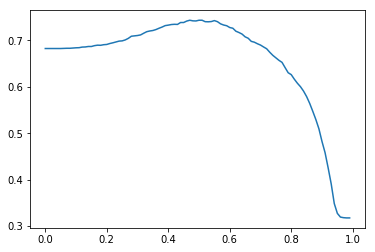

In [109]:
i=0
score=[]
X=[]
while i <1:
    temp=sub
    temp = [1 if x >= i else 0 for x in temp]
    score.append(accuracy_score(Y_dev,temp))
    X.append(i)
    temp=sub
    i=i+0.01
plt.plot(X,score)
plt.show()